In [1]:
# Importing standard Qiskit libraries and configuring account
from qiskit import *
from qiskit import IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')

In [2]:
import csv

In [3]:
case = 'l32k0.6h0.0sd5'

In [4]:
with open("data/"+case+".csv") as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    image = np.array([[float(d) for d in row] for row in spamreader])

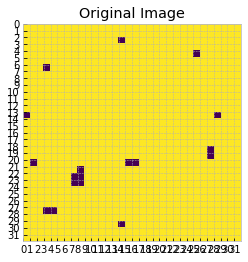

In [5]:
# Function for plotting the image using matplotlib
def plot_image(img, title: str):
    plt.title(title)
    plt.xticks(range(img.shape[0]))
    plt.yticks(range(img.shape[1]))
    plt.imshow(img, extent=[0, img.shape[0], img.shape[1], 0], cmap='viridis')
    plt.show()
    
plot_image(image, 'Original Image')

In [6]:
# Convert the raw pixel values to probability amplitudes
def amplitude_encode(img_data):
    
    # Calculate the RMS value
    rms = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))
    
    # Create normalized image
    image_norm = []
    for arr in img_data:
        for ele in arr:
            image_norm.append(ele / rms)
        
    # Return the normalized image as a numpy array
    return np.array(image_norm)

# Get the amplitude ancoded pixel values
# Horizontal: Original image
image_norm_h = amplitude_encode(image)

# Vertical: Transpose of Original image
image_norm_v = amplitude_encode(image.T)

In [7]:
# Initialize some global variable for number of qubits
data_qb = 10
anc_qb = 1
total_qb = data_qb + anc_qb

# Initialize the amplitude permutation unitary
D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)

In [8]:
print(D2n_1)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]]


In [20]:
# Create the circuit for horizontal scan
qc_h = QuantumCircuit(total_qb,1)
qc_h.initialize(image_norm_h, range(1, total_qb))
qc_h.h(0)
qc_h.unitary(D2n_1, range(total_qb),label='Decrement')
qc_h.h(0)
#display(qc_h.draw('mpl', fold=-1))

# Create the circuit for vertical scan
qc_v = QuantumCircuit(total_qb,1)
qc_v.initialize(image_norm_v, range(1, total_qb))
qc_v.h(0)
qc_v.unitary(D2n_1, range(total_qb))
qc_v.h(0)
#display(qc_v.draw('mpl', fold=-1))

# Combine both circuits into a single list
circ_list = [qc_h, qc_v]

In [21]:
qc_h.measure([0],[0])
qc_v.measure([0],[0])

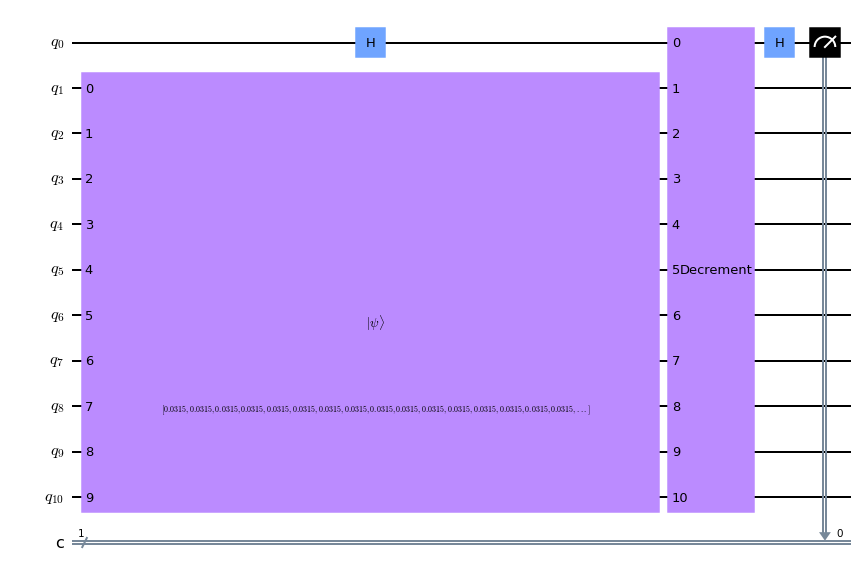

In [11]:
qc_h.draw('mpl')

In [12]:
# Simulating the cirucits
back = Aer.get_backend('aer_simulator')

In [13]:
job = back.run(qc_h,shots=1024)

In [14]:
cts = job.result().get_counts()

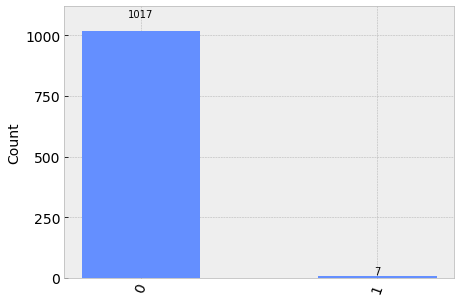

In [16]:
plot_histogram(cts)

In [22]:
job = back.run(qc_v,shots=1024)

In [23]:
cts = job.result().get_counts()

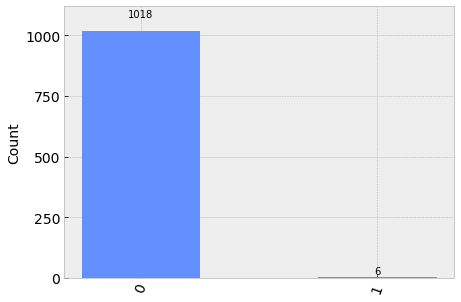

In [24]:
plot_histogram(cts)

### The last qubit is overwhelmingly 0, indicating that there are no domain walls, and that the model is in the ordered phase!

In [ ]:
res_h, res_v = results[0], results[1]

# Classical postprocessing

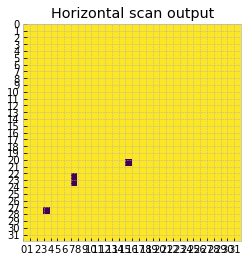

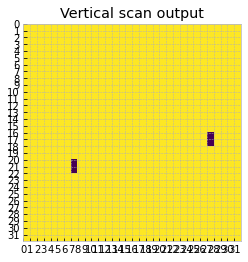

In [20]:
# Classical postprocessing for plotting the output

# Defining a lambda function for
# thresholding to binary values
threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)

# Selecting odd states from the raw statevector and
# reshaping column vector of size 64 to an 8x8 matrix
edge_scan_h = np.abs(np.array([1 if threshold(sv_h[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(32, 32)
edge_scan_v = np.abs(np.array([1 if threshold(sv_v[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(32, 32).T

# Plotting the Horizontal and vertical scans
plot_image(edge_scan_h, 'Horizontal scan output')
plot_image(edge_scan_v, 'Vertical scan output')

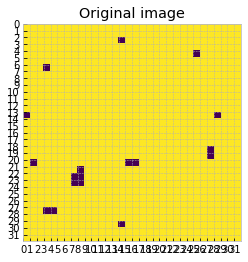

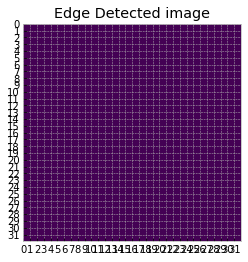

In [21]:
# Combining the horizontal and vertical component of the result
edge_scan_sim = edge_scan_h | edge_scan_v

# Plotting the original and edge-detected images
plot_image(image, 'Original image')
plot_image(edge_scan_sim, 'Edge Detected image')

In [22]:
tot_edges = np.sum(edge_scan_sim)
print(tot_edges)

1024


### Actually Running Classifier

In [26]:
# 16 x 16
%run sweeping.py

The average number of edges at k=0.0 is equal to
183.0



The average number of edges at k=0.1 is equal to
176.96875



The average number of edges at k=0.2 is equal to
157.875



The average number of edges at k=0.3 is equal to
133.1875



The average number of edges at k=0.4 is equal to
89.6875



The average number of edges at k=0.5 is equal to
25.375



The average number of edges at k=0.6 is equal to
7.25



The average number of edges at k=0.7 is equal to
2.28125



The average number of edges at k=0.8 is equal to
0.71875



The average number of edges at k=0.9 is equal to
0.1875





In [1]:
# 32 x 32
%run sweeping.py

The average number of edges at k=0.2 is equal to
624



The average number of edges at k=0.3 is equal to
558



The average number of edges at k=0.4 is equal to
369



The average number of edges at k=0.5 is equal to
114



The average number of edges at k=0.6 is equal to
37



The average number of edges at k=0.7 is equal to
21



The average number of edges at k=0.8 is equal to
0



The average number of edges at k=0.9 is equal to
6



